# ANALIZA SERIILOR DE DATE CU MODELE ARIMA

Într-o economie axată tot mai mult pe dezvoltarea de surse sustenabile de energie, monitorizarea și prognozarea consumului de energie electrică devine un subiect din ce în ce mai important.

O prognoză precisă poate ajuta la planificarea eficientă a producției și distribuției, în vederea evitării situațiilor de tipul surplus sau deficit de consum.

Prin acest proiect ne propunem să analizăm cum a evoluat consumul de energie electrică din România, în ultimele 2 decenii, ca urmare a evoluției tehnologice și a schimbarilor structurale de la nivel economic și, totodată, să modelăm prognoze asupra acestui consum prin intermediul modelelor de tipul ARIMA și SARIMA.


Încărcarea librăriilor și a datelor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.impute import SimpleImputer
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.pyplot as tsplot
%matplotlib inline
import seaborn as sns
from datetime import datetime
from season_polar_plots import SeasonData
pd.options.display.float_format = '{:.2f}'.format
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pmdarima as pm
from pandas.tseries.offsets import DateOffset

In [2]:
df = pd.read_csv("C:/Users/tea20/OneDrive/Desktop/master/econometrie_avansata/consum_gWh_RO.csv")

# Analiza exploratorie a datelor

Setul de date analizat cuprinde un număr de 194 de observații referitoare la consumul lunar de energie electrică exprimat in GWh în Romania, în perioada ianuarie 2008 - februarie 2024.

In [3]:
df.head()

,Date,gWh_RO
0,2008-01,5087
1,2008-02,4693
2,2008-03,4722
3,2008-04,4336
4,2008-05,4281


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    194 non-null    object
 1   gWh_RO  194 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [5]:
df.describe()

,gWh_RO
count,194.00
mean,4372.11
std,371.86
min,3537.00
25%,4118.00
50%,4346.00
75%,4634.25
max,5295.00


La o primă vedere, putem constata că în perioada analizată consumul mediu de energie electrică înregistrat a fost de 4372.11 GWh, valoarea minimă fiind de 3537 GWh, în timp ce valoarea maximă a înregistrat un consum de 5295 GWh.

Distribuția setului de date este redată in histograma de mai jos, ce pare să indice stabilitate în consum.

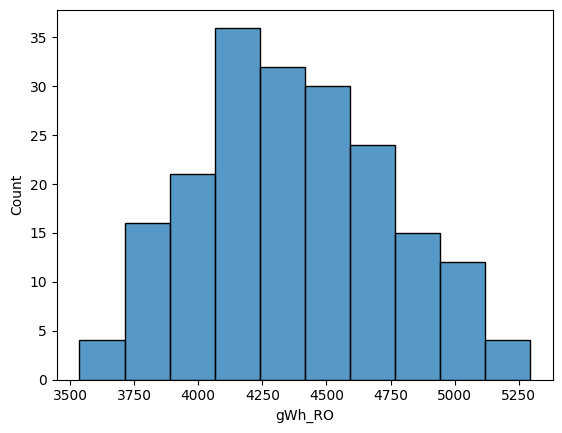

In [4]:
hist_y = sns.histplot(data=df, x='gWh_RO')

In [10]:
df.isna().mean()

Date     0.00
gWh_RO   0.00
dtype: float64

Setul de date nu conține valori lipsa. În continuare, am simulat un nou set de date pe baza celui inițial, dar de data aceasta conținând valori lipsa pentru a arata cum ar trebui tratată o situație de acest gen.

Am ales varianta de a înlcui valorile lipsă cu media valorilor existente în setul de date.

In [5]:
df2 = pd.read_csv("C:/Users/tea20/OneDrive/Desktop/master/econometrie_avansata/date_lipsa_proiect.csv")
df2

,Date,gWh_RO
0,2008-01,5087.00
1,2008-02,4693.00
2,2008-03,4722.00
3,2008-04,4336.00
4,2008-05,4281.00
...,...,...
189,2023-10,3930.00
190,2023-11,4221.00
191,2023-12,4489.00
192,2024-01,4661.00


In [12]:
df2.isna().mean()

Date     0.00
gWh_RO   0.03
dtype: float64

In [6]:

df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m')

consumption_data = df2[['gWh_RO']]  
my_imputer = SimpleImputer(strategy='mean')

consumption_imputed = my_imputer.fit_transform(consumption_data)

df2['gWh_RO'] = consumption_imputed

In [14]:
df2.isna().mean()

Date     0.00
gWh_RO   0.00
dtype: float64

Definirea funcțiilor utilizate

In [4]:
def test_stationarity(timeseries):
   

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Difference')
    plt.legend(loc='best')
    plt.title('Stationarity')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [5]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [6]:
def select_best_model(models):
    selected_models = []
    for model in models:
        summary = model.summary()
        results_as_html = summary.tables[1].as_html()
        df_params = pd.read_html(results_as_html, header=0, index_col=0)[0]
        
        if all(df_params['P>|z|'] < 0.05):
            selected_models.append(model)
    
    if selected_models:
        best_aic = min(model.aic for model in selected_models)
        best_model = next(model for model in selected_models if model.aic == best_aic)
        return best_model
    else:
        return None

# Analiza Seriei de Timp

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


Text(0.5, 1.0, 'Monthy Electricity Consumption in Romania 2008-2024')

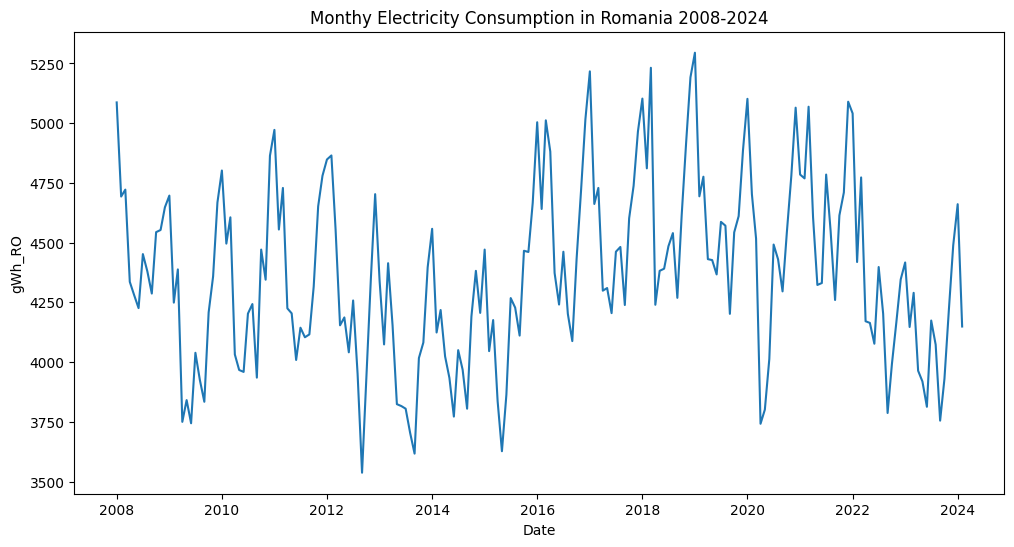

In [8]:

plt.figure(figsize=(12,6))
g = sns.lineplot(data=df, x='Date',y='gWh_RO')
g.set_title('Monthy Electricity Consumption in Romania 2008-2024')

Pe baza graficului de tip linie reprezentat mai sus, se poate observa evoluția consumului de energie electrică în perioada 2008-2024, la nivelul României.

Se observă un model sezonier în care consumul de energie electrică crește în timpul iernii din cauza necesității de încalzire, iar mai apoi scade odată cu venirea lunilor mai călduroase. Cele mai mici valori ale consumului se situează în perioada 2012-2015, moment în care directivele europene au abordat o nouă strategie de eficientizare a consumului, bazată pe reducerea acestuia. De asemenea, odată cu anul 2022 consumul de electricitate pare să înregistreze din nou valori mai scăzute, ca urmare a implementării a cât mai multe surse de energie sustenabilă.

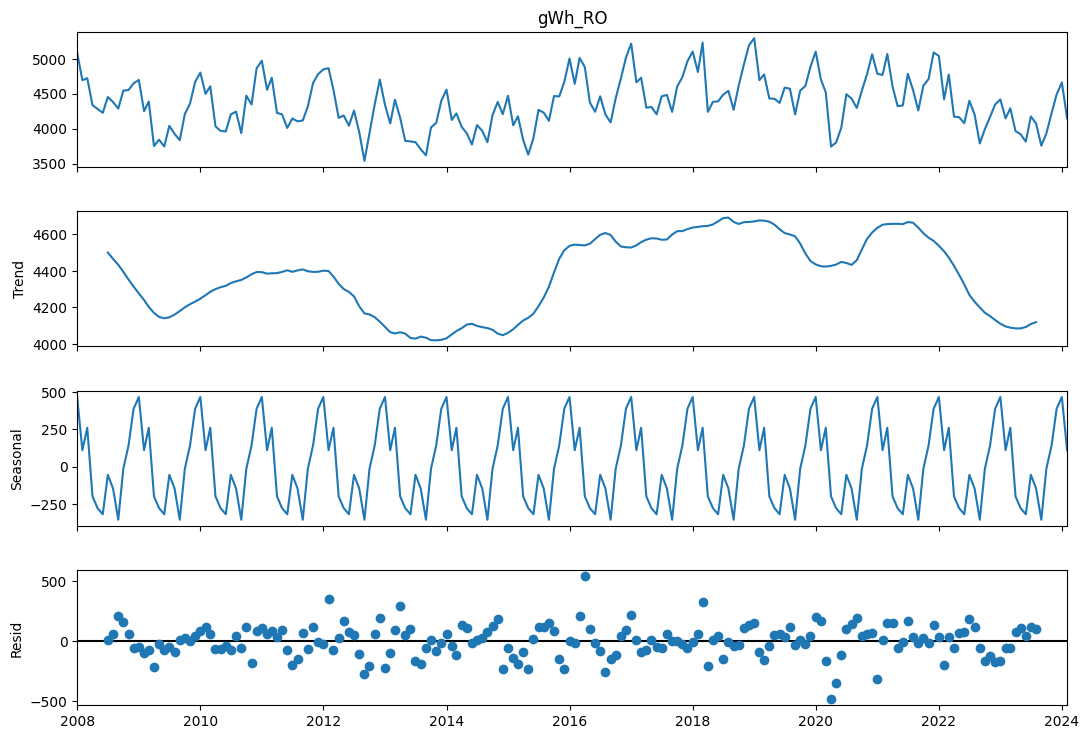

In [8]:
decomposition = seasonal_decompose(df['gWh_RO'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

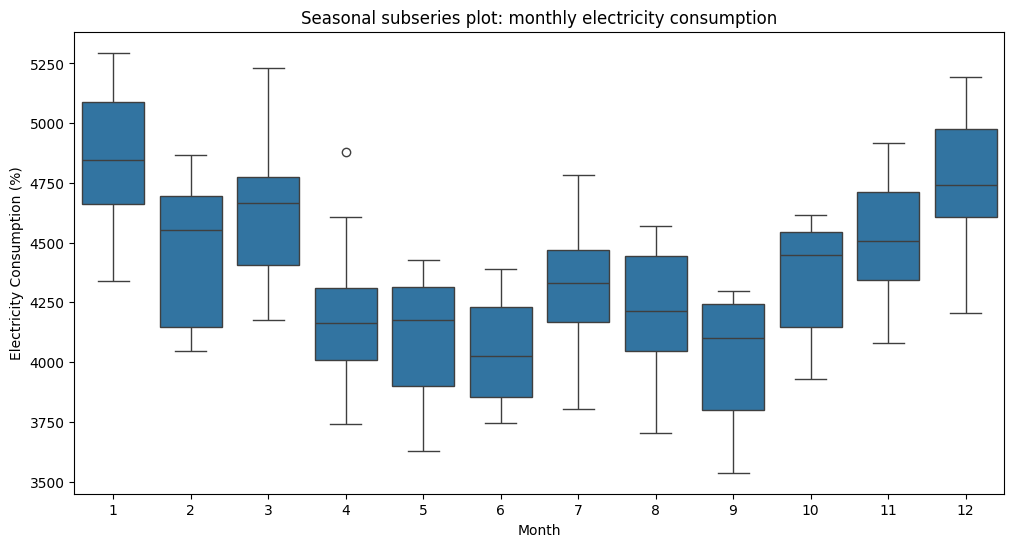

In [9]:
df['Date'] = df.index.month
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x='Date', y='gWh_RO', ax=ax)
ax.set_title('Seasonal subseries plot: monthly electricity consumption')
ax.set_xlabel('Month')
ax.set_ylabel('Electricity Consumption (%)')
plt.show()

Prin graficul de tip boxplot se arată distribuția consumului de energie electrică pentru fiecare lună din an.

Se poate observa o variație sezonieră deoarece consumul de energie crește iarna și toamna târziu dar scade primăvara și vara, când este necesară mai puțină încălzire. Pentru luna a 4-a, boxplotul arată existența unui outlier ceea ce înseamnă că în luna Aprilie a unuia dintre anii analizați consumul de energie electrică a înregistrat valori foarte mari comparativ cu restul anilor.   

In [10]:
from season_polar_plots import SeasonData

In [11]:
# Extract month and year from the index (date)
df['Month'] = df.index.month
df['Year'] = df.index.year

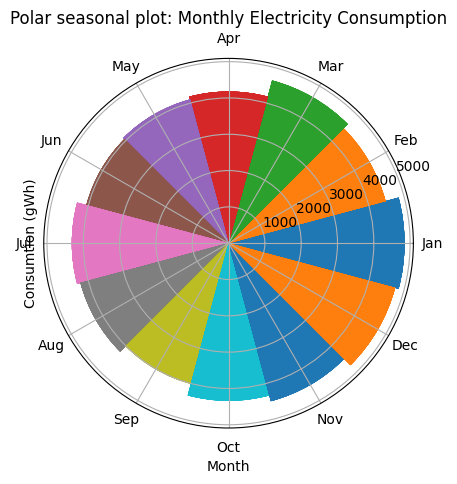

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Convert month to radians for plotting, treating each month as 30 degrees
theta = (np.pi / 6) * (df['Month'] - 1)

monthly_sales = df.groupby('Month')['gWh_RO'].mean()

for month in range(1, 13):  
    indices = df['Month'] == month  
    ax.bar(theta[indices], [monthly_sales[month]] * sum(indices), width=np.pi/6, bottom=0.0, alpha=0.6)

ax.set_xticks(np.pi/6 * np.arange(12))  
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('Polar seasonal plot: Monthly Electricity Consumption')
ax.set_xlabel('Month')
ax.set_ylabel('Consumtion (gWh)')

plt.show()

Pe baza graficului de tip polar se evidențiază foarte bine aspectele periodice ale datelor analizate, și anume un consum ridicat de energie pe timpul iernii, mai ales in lunile Decembrie și Ianuarie. Aceste cicluri ce se repetă în mod regulat reflectă o cerere mai mare pentru încălzire în timpul sezonului rece și o cerere mai mică pentru răcire în timpul sezonului cald.

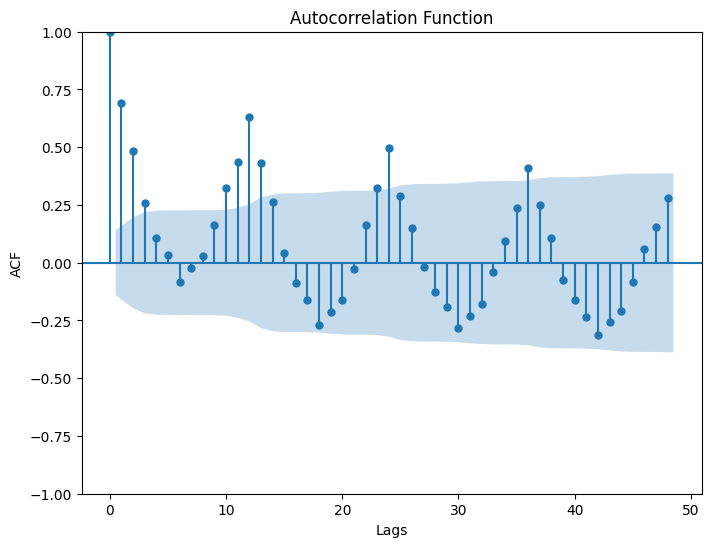

In [13]:
a = df['gWh_RO']

plt.figure(figsize=(8, 6))
plot_acf(a, lags=48, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()


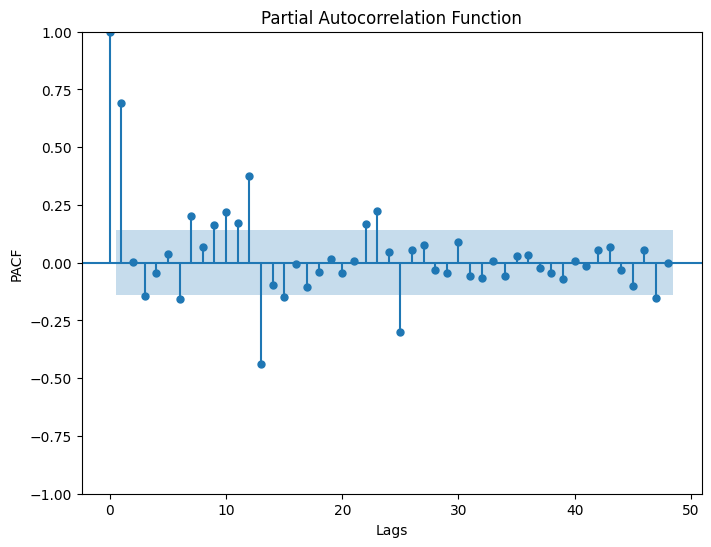

In [14]:

# Plot PACF
plt.figure(figsize=(8, 6))
plot_pacf(a, lags=48, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()


Pe baza graficelor ACF și PACF, putem constata că seria nu este staționară. Vom testa, totuși, în continuare staționaritatea cu ajutorul ADF.

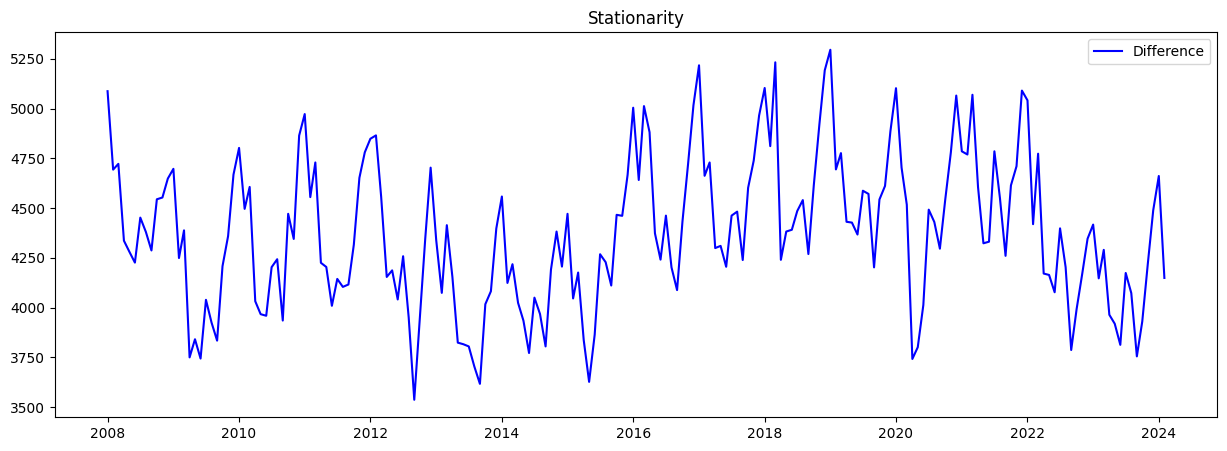

Results of Dickey-Fuller Test:
Test Statistic                 -2.33
p-value                         0.16
#Lags Used                     14.00
Number of Observations Used   179.00
Critical Value (1%)            -3.47
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [15]:
test_stationarity(df['gWh_RO'])

Pentru acest lucru, vom folosi Testul Augmented Dickey Fuller (ADF) ce sustine următoarele ipoteze:


*   H0: Seria este non-staționară
*   H1: Seria este staționară

Pe baza output-ului rezultat, valorea testului este mai mare decât valoarea critică iar p-value este mai mare decât 0.05.

Prin urmare, Ipoteza nulă nu poate fi respinsă, deci seria nu este staționară, fiind necesară o diferențiere.


In [16]:
df_diff = df.diff()
df_diff = df_diff.dropna()


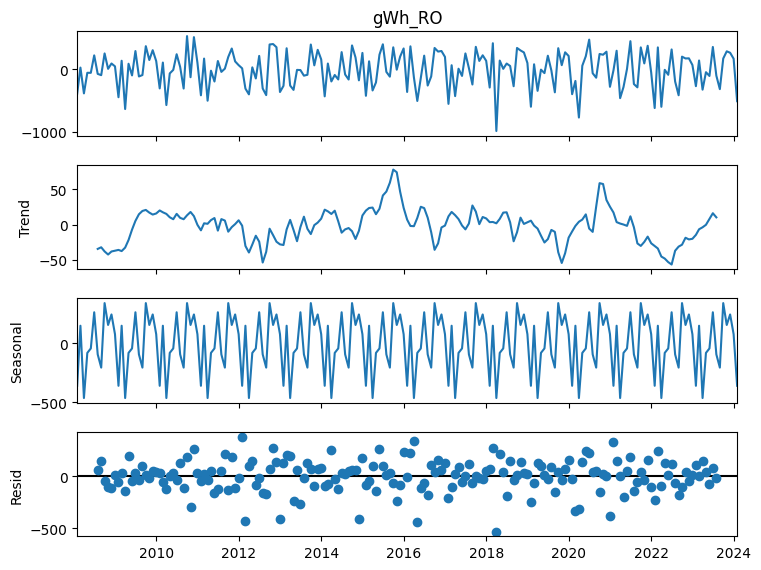

In [17]:
decomposition = seasonal_decompose(df_diff['gWh_RO'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(8, 6)
plt.show()

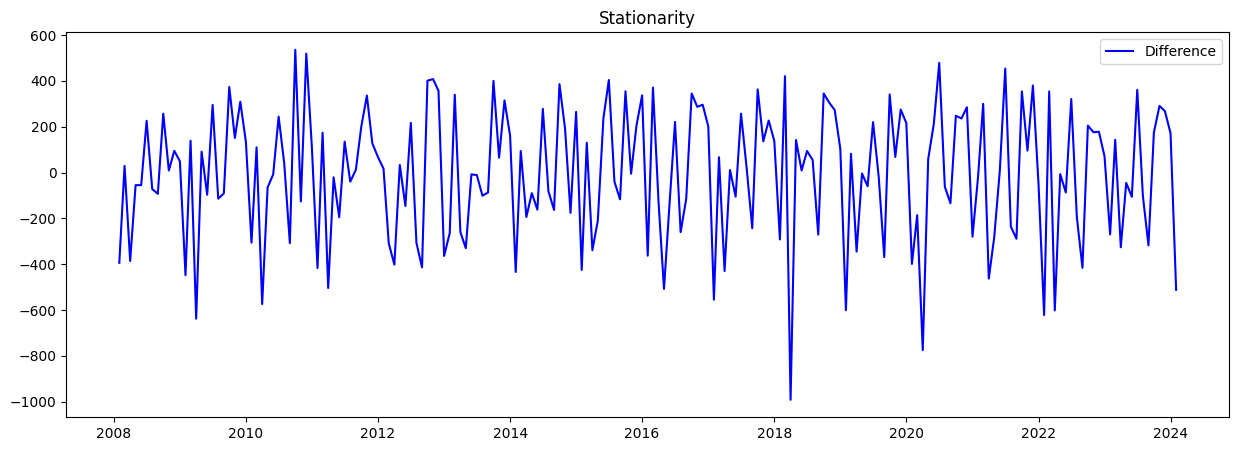

Results of Dickey-Fuller Test:
Test Statistic                 -3.70
p-value                         0.00
#Lags Used                     13.00
Number of Observations Used   179.00
Critical Value (1%)            -3.47
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [18]:
test_stationarity(df_diff['gWh_RO'])

Valoarea critică este mai mare decât valoarea statistică, iar p-value înregistrează o valoare inferioară pragului de 0.05.

# Modelarea seriei folosind ARIMA

în continuare, vom folosi modelul ARIMA pentru a prognoza consumul de energie electrică.

Modelul ARIMA reprezintă o combinație între 3 componente și anume: componenta Autoregresivă, componenta de integrare și componenta de Medie Mobilă.
Ordinul acestui model este de forma (p,d,q).  

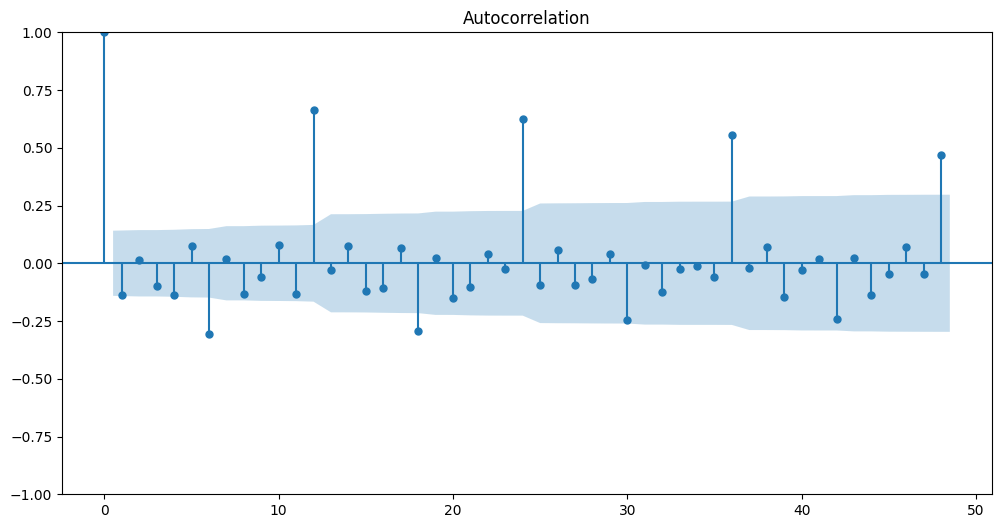

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))  
sm.graphics.tsa.plot_acf(df_diff['gWh_RO'], lags=48, ax=ax)
plt.show()

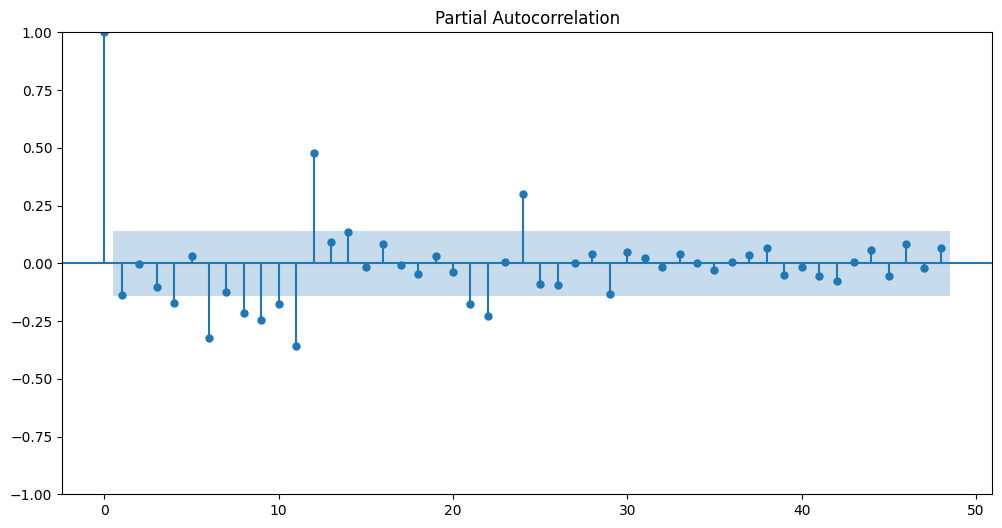

In [20]:
fig, ax = plt.subplots(figsize=(12, 6)) 
sm.graphics.tsa.plot_pacf(df_diff['gWh_RO'], lags=48, ax=ax)
plt.show()

In [21]:
model = pm.auto_arima(df['gWh_RO'],
                      seasonal=False,              
                      trace=True,
                      d=1,      
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True)   

# Summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2735.123, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2732.963, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2732.857, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2733.179, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2734.571, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2730.881, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2732.622, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2731.009, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.225 seconds
                               SARIMAX Results 

In [21]:
model = sm.tsa.ARIMA(df['gWh_RO'],order = (2,1,2))
model_fit_a1 = model.fit()
print(model_fit_a1.summary())

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\te

                               SARIMAX Results                                
Dep. Variable:                 gWh_RO   No. Observations:                  194
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1348.952
Date:                Thu, 30 May 2024   AIC                           2707.904
Time:                        01:09:55   BIC                           2724.217
Sample:                    01-01-2008   HQIC                          2714.510
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2825      0.051     -5.551      0.000      -0.382      -0.183
ar.L2          0.7175      0.049     14.656      0.000       0.622       0.813
ma.L1         -0.0004      2.397     -0.000      1.0

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
model = sm.tsa.ARIMA(df['gWh_RO'],order = (1,1,0))
model_fit_a2 = model.fit()
print(model_fit_a2.summary())

                               SARIMAX Results                                
Dep. Variable:                 gWh_RO   No. Observations:                  194
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1363.505
Date:                Thu, 30 May 2024   AIC                           2731.009
Time:                        01:10:02   BIC                           2737.535
Sample:                    01-01-2008   HQIC                          2733.652
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1470      0.085     -1.731      0.083      -0.313       0.019
sigma2      7.998e+04   8953.466      8.932      0.000    6.24e+04    9.75e+04
Ljung-Box (L1) (Q):                   0.01   Jarque-

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [23]:
model = sm.tsa.ARIMA(df['gWh_RO'],order = (0,1,1))
model_fit_a3 = model.fit()
print(model_fit_a3.summary())

                               SARIMAX Results                                
Dep. Variable:                 gWh_RO   No. Observations:                  194
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1363.441
Date:                Thu, 30 May 2024   AIC                           2730.881
Time:                        01:10:05   BIC                           2737.407
Sample:                    01-01-2008   HQIC                          2733.524
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1550      0.085     -1.829      0.067      -0.321       0.011
sigma2      8.038e+04   8876.689      9.055      0.000     6.3e+04    9.78e+04
Ljung-Box (L1) (Q):                   0.03   Jarque-

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [24]:
model = sm.tsa.ARIMA(df['gWh_RO'],order = (1,1,1))
model_fit_a4 = model.fit()
print(model_fit_a4.summary())

                               SARIMAX Results                                
Dep. Variable:                 gWh_RO   No. Observations:                  194
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1351.875
Date:                Thu, 30 May 2024   AIC                           2709.750
Time:                        01:10:08   BIC                           2719.538
Sample:                    01-01-2008   HQIC                          2713.714
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7059      0.054     13.024      0.000       0.600       0.812
ma.L1         -0.9984      0.085    -11.811      0.000      -1.164      -0.833
sigma2      7.036e+04   1.07e+04      6.591      0.0

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [25]:
model = sm.tsa.ARIMA(df['gWh_RO'],order = (2,1,1))
model_fit_a5 = model.fit()
print(model_fit_a5.summary())

                               SARIMAX Results                                
Dep. Variable:                 gWh_RO   No. Observations:                  194
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1351.875
Date:                Thu, 30 May 2024   AIC                           2711.749
Time:                        01:10:11   BIC                           2724.800
Sample:                    01-01-2008   HQIC                          2717.034
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7059      0.080      8.878      0.000       0.550       0.862
ar.L2          0.0003      0.086      0.003      0.998      -0.168       0.168
ma.L1         -0.9998      0.839     -1.192      0.2

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\te

In [26]:
model = sm.tsa.ARIMA(df['gWh_RO'],order = (1,1,2))
model_fit_a6 = model.fit()
print(model_fit_a6.summary())

                               SARIMAX Results                                
Dep. Variable:                 gWh_RO   No. Observations:                  194
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1351.875
Date:                Thu, 30 May 2024   AIC                           2711.749
Time:                        01:10:13   BIC                           2724.800
Sample:                    01-01-2008   HQIC                          2717.034
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7061      0.083      8.493      0.000       0.543       0.869
ma.L1         -1.0000      0.737     -1.357      0.175      -2.444       0.444
ma.L2          0.0002      0.121      0.002      0.9

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [27]:
model = sm.tsa.ARIMA(df['gWh_RO'],order = (0,1,2))
model_fit_a7 = model.fit()
print(model_fit_a7.summary())

                               SARIMAX Results                                
Dep. Variable:                 gWh_RO   No. Observations:                  194
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1363.311
Date:                Thu, 30 May 2024   AIC                           2732.622
Time:                        01:10:16   BIC                           2742.411
Sample:                    01-01-2008   HQIC                          2736.586
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1670      0.087     -1.915      0.055      -0.338       0.004
ma.L2         -0.0507      0.072     -0.702      0.483      -0.192       0.091
sigma2       8.02e+04   9018.399      8.892      0.0

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [28]:
model_fits = [model_fit_a1, model_fit_a2, model_fit_a3, model_fit_a4, model_fit_a5, model_fit_a6, model_fit_a7]

aic_values = [model.aic for model in model_fits]
min_aic = min(aic_values)
best_model_index = aic_values.index(min_aic)

print("Smallest AIC:", min_aic)
print( model_fits[best_model_index].summary())

Smallest AIC: 2707.9039352638238
                               SARIMAX Results                                
Dep. Variable:                 gWh_RO   No. Observations:                  194
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1348.952
Date:                Thu, 30 May 2024   AIC                           2707.904
Time:                        01:10:22   BIC                           2724.217
Sample:                    01-01-2008   HQIC                          2714.510
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2825      0.051     -5.551      0.000      -0.382      -0.183
ar.L2          0.7175      0.049     14.656      0.000       0.622       0.813
ma.L1         -0.00

In [31]:
best_model = select_best_model(model_fits)
if best_model:
    print("Best model:\n", best_model.summary())
else:
    print("None of the models.")

Best model:
                                SARIMAX Results                                
Dep. Variable:                 gWh_RO   No. Observations:                  194
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1351.875
Date:                Thu, 30 May 2024   AIC                           2709.750
Time:                        01:12:18   BIC                           2719.538
Sample:                    01-01-2008   HQIC                          2713.714
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7059      0.054     13.024      0.000       0.600       0.812
ma.L1         -0.9984      0.085    -11.811      0.000      -1.164      -0.833
sigma2      7.036e+04   1.07e+04      6

C:\Users\tea20\AppData\Local\Temp\ipykernel_28284\64653699.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_params = pd.read_html(results_as_html, header=0, index_col=0)[0]
C:\Users\tea20\AppData\Local\Temp\ipykernel_28284\64653699.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_params = pd.read_html(results_as_html, header=0, index_col=0)[0]
C:\Users\tea20\AppData\Local\Temp\ipykernel_28284\64653699.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_params = pd.read_html(results_as_html, header=0, index_col=0)[0]
C:\Users\tea20\AppData\Local\Temp\ipykernel_28284\64653699.py:6: FutureWarning: Passing 

Pe baza criteriilor AIC, BIC și HQIC, modelul ARIMA(1,1,1) pare a fi cel mai optim deoarece prezintă cele mai mici valori pentru 2 din cele 3 criterii.

Parametrii modelului sunt semnificativi din punct de vedere statistic.

Testul Ljung Box indica faptul ca nu există autocorelare în reziduuri (0.91>0.1), iar testul Jarque Bera sugerează că reziduurile sunt normal distribuite (0.17>0.05).

Se poate concluziona că ARIMA(1,1,1) este adecvat pentru modelarea consumului de energie, având parametrii semnificativi și trecând testele de diagnostice asupra reziduurilor.

In [32]:
size = int(len(df) - 30)
train, test = df['gWh_RO'][0:size], df['gWh_RO'][size:len(df)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = sm.tsa.ARIMA(history, order=(1,1,1))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 4594.240589, expected = 4260.000000
predicted = 4288.102140, expected = 4614.000000
predicted = 4561.474781, expected = 4710.000000
predicted = 4704.698436, expected = 5090.000000
predicted = 5041.896609, expected = 5041.000000


C:\Users\tea20\AppData\Local\Temp\ipykernel_28284\979349821.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted = 5057.237726, expected = 4419.000000
predicted = 4464.182205, expected = 4773.000000
predicted = 4711.997619, expected = 4171.000000
predicted = 4274.334194, expected = 4164.000000
predicted = 4148.496362, expected = 4077.000000
predicted = 4092.861537, expected = 4398.000000
predicted = 4347.190456, expected = 4203.000000
predicted = 4242.844274, expected = 3787.000000
predicted = 3841.617890, expected = 3992.000000
predicted = 3953.251232, expected = 4168.000000
predicted = 4145.835037, expected = 4346.000000
predicted = 4323.148698, expected = 4417.000000
predicted = 4410.193698, expected = 4147.000000
predicted = 4187.118770, expected = 4290.000000
predicted = 4263.803932, expected = 3964.000000
predicted = 4016.978648, expected = 3919.000000
predicted = 3917.636620, expected = 3813.000000
predicted = 3828.896082, expected = 4174.000000
predicted = 4117.580699, expected = 4073.000000
predicted = 4097.948767, expected = 3755.000000
predicted = 3804.086305, expected = 3930

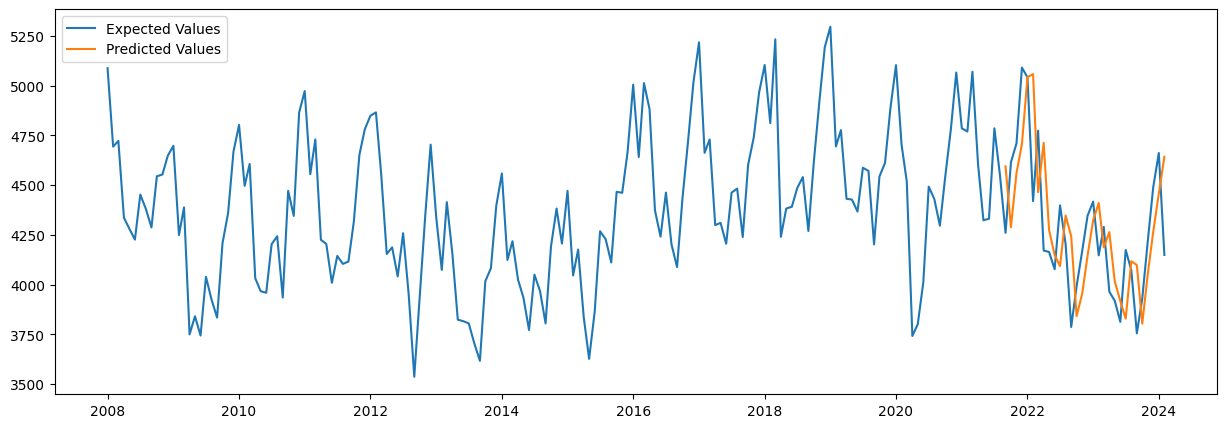

In [33]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['gWh_RO'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [12]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 285.6210


In [34]:
mape = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.4f' % mape)

Test MAPE: 0.0568


In [38]:
future_dates_arima = [df.index[-1] + DateOffset(months = x) for x in range(0,24)]

df_arima = pd.DataFrame(index = future_dates_arima[1:],columns = df.columns)

forecast = pd.concat([df,df_arima])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast=forecast.drop(['Month'], axis=1)
forecast=forecast.drop(['Year'], axis=1)
forecast.head()

,gWh_RO,ARIMA_Forecast_Function
2008-01-01,5087,NaN
2008-02-01,4693,NaN
2008-03-01,4722,NaN
2008-04-01,4336,NaN
2008-05-01,4281,NaN


In [39]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df_arima)):

    model = sm.tsa.ARIMA(ARIMA_history_f, order = (1,1,1))
    model_fit = model.fit()

    output = model_fit.forecast()[0]

    ARIMA_history_f.append(output)
    f1.append(output)

for i in range(len(f1)):
    forecast.iloc[194 + i,1] = f1[i]
forecast.tail()

,gWh_RO,ARIMA_Forecast_Function
2025-09-01,NaN,4582.09
2025-10-01,NaN,4582.09
2025-11-01,NaN,4582.09
2025-12-01,NaN,4582.09
2026-01-01,NaN,4582.09


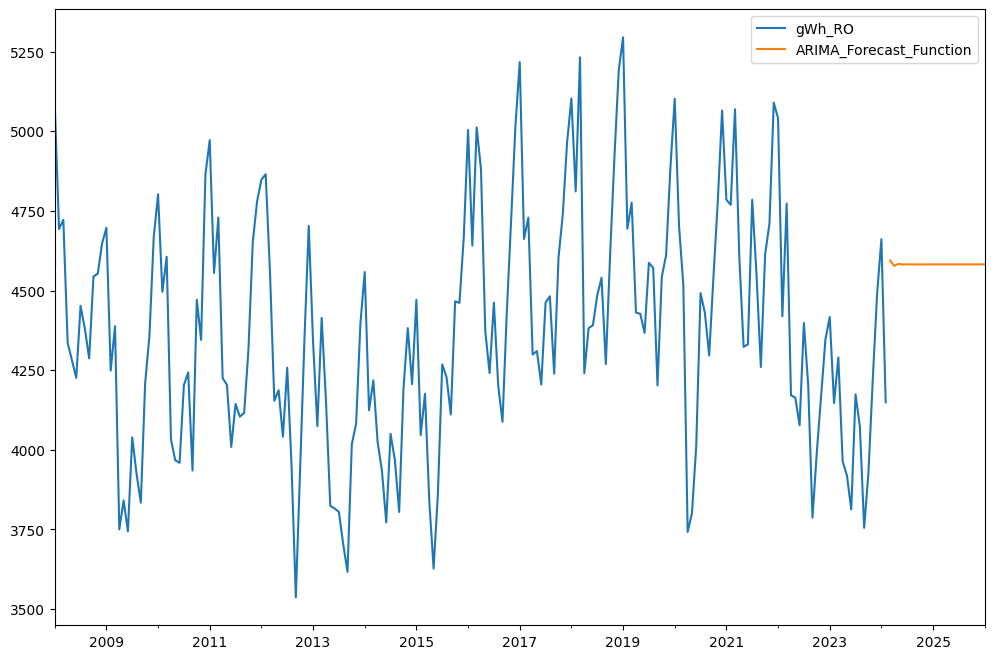

In [40]:
forecast[['gWh_RO','ARIMA_Forecast_Function']].plot(figsize = (12,8));

Se poate observa că modelul ARIMA nu a captat sezonalitatea datelor și nu a reușit să realizeze o prognoză veridică. De aceea, vom lua în calcul existența sezonalității, cu ajutorul modelului SARIMA.

# Modelarea seriei folosind SARIMA

SARIMA este o extensie a modelului ARIMA, care poate gestiona efectele sezoniere ale datelor. Acesta include două tipuri de ordine: (p,d,q) și (P,D,Q,M). Ordinea (p,d,q) este similară cu cea a modelului ARIMA. Ordinea sezonieră (P,D,Q,M), unde (P,D,Q) sunt similare cu (p,d,q) din modelul ARIMA, se ocupă de specificul sezonier. Criteriile de selecție ale modelului sunt similare, având o condiție importantă, aceea de a gestiona sezonalitatea prin diferențierea datelor cu frecvența perioadei sau periodicitatea sezoniere, M.


Datele noastre sunt în format lunar și perioada sezonieră este de un an. Prin urmare, diferențiem datele deja diferențiate cu o periodicitate, M, de valoare 12.

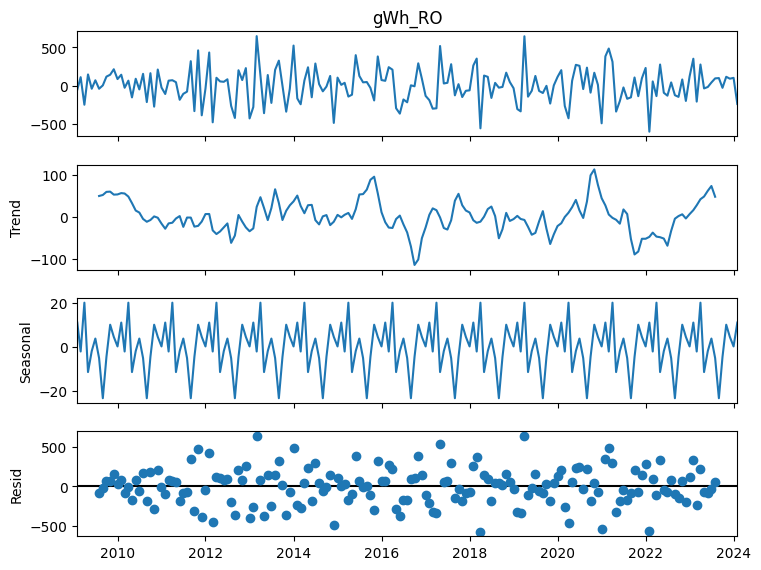

In [22]:
df_diff_seas = df_diff.diff(12)
df_diff_seas = df_diff_seas.dropna()
decomposition = seasonal_decompose(df_diff_seas['gWh_RO'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(8, 6)
plt.show()

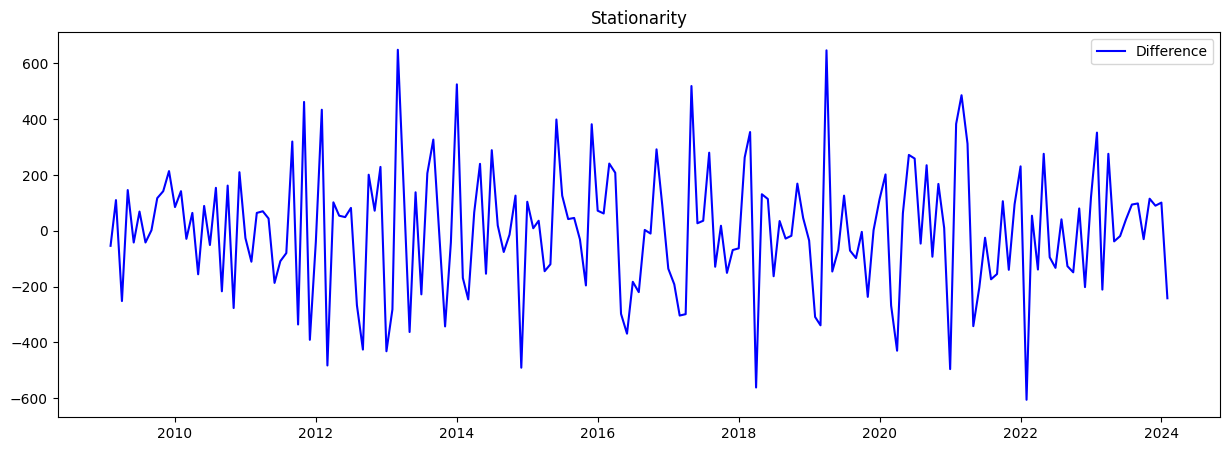

Results of Dickey-Fuller Test:
Test Statistic                 -5.94
p-value                         0.00
#Lags Used                     11.00
Number of Observations Used   169.00
Critical Value (1%)            -3.47
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [23]:
test_stationarity(df_diff_seas['gWh_RO'])
fig.set_size_inches(8, 6)
plt.show()

Din rezultatele testului Augmented Dickey Fuller, testul statistic este mai mic decât toate valorile critice, 0.05 > valoarea p (0.00)
Putem respinge ipoteza nulă și accepta ipoteza alternativă, adică putem spune că seria este staționară.

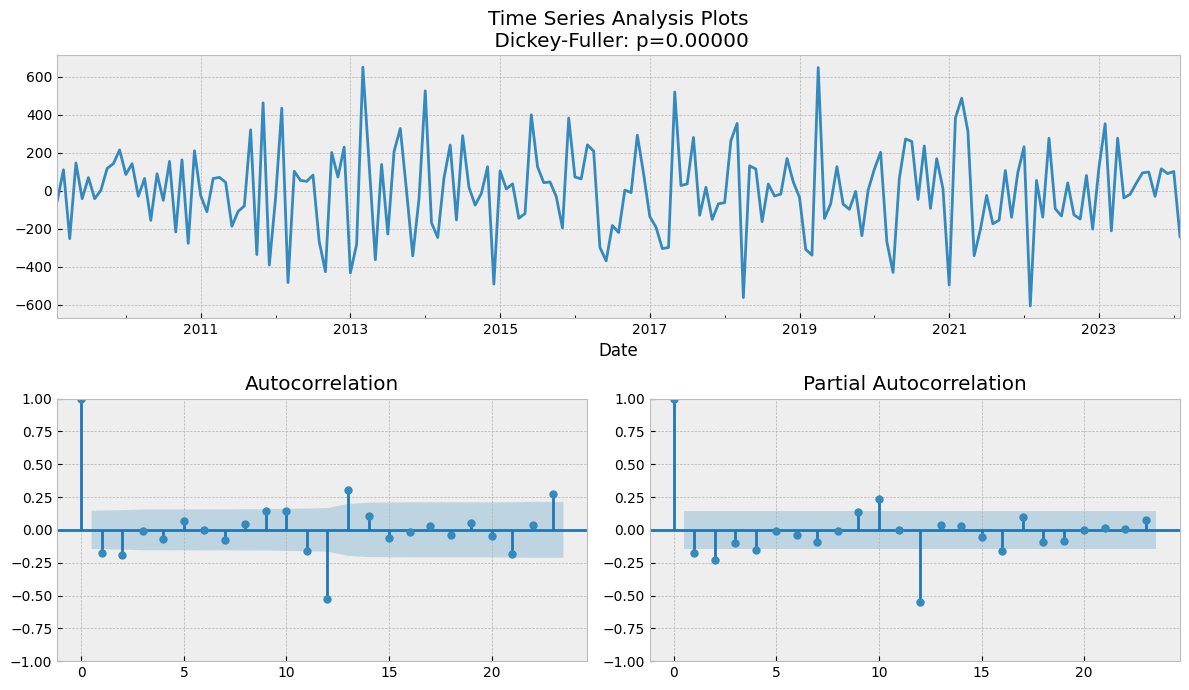

In [24]:
tsplot(df_diff_seas['gWh_RO'])


Conform ACF și PACF, am putea alege ordinul P și Q 2 sau 1, însă lagurile nu ies semnificativ din interval. De aceea, pentru a determina cei mai potriviți parametri ai modelului SARIMA, aplicăm funcția auto_arima din biblioteca pmdarima.

In [25]:
model = pm.auto_arima(df['gWh_RO'],
                      seasonal=True,   
                      m=12, 
                      trace=True,
                      d=1,
                      D=1,          
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True)   

print(model.summary())




Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=5.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2479.736, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2418.380, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2476.158, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2397.516, Time=1.07 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2405.641, Time=0.67 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2394.403, Time=1.66 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2411.669, Time=0.75 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.07 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2396.198, Time=1.77 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=2392.8

Vom testa modelele, alternând între (p,d,q)x(P,D,Q,12)

In [26]:
model = sm.tsa.statespace.SARIMAX(df['gWh_RO'],order = (2,1,2),seasonal_order = (1,1,1,12))
model_fit1 = model.fit()

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
model = sm.tsa.statespace.SARIMAX(df['gWh_RO'],order = (2,1,0),seasonal_order = (0,1,2,12))
model_fit2 = model.fit()

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
model = sm.tsa.statespace.SARIMAX(df['gWh_RO'],order = (1,1,1),seasonal_order = (0,1,2,12))
model_fit3 = model.fit()

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [29]:
model = sm.tsa.statespace.SARIMAX(df['gWh_RO'],order = (1,1,1),seasonal_order = (1,1,1,12))
model_fit4 = model.fit()

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
model = sm.tsa.statespace.SARIMAX(df['gWh_RO'],order = (1,1,1),seasonal_order = (1,1,1,12))
model_fit5 = model.fit()

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [31]:
model = sm.tsa.statespace.SARIMAX(df['gWh_RO'],order = (0,1,1),seasonal_order = (0,1,0,12))
model_fit6 = model.fit()

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
model = sm.tsa.statespace.SARIMAX(df['gWh_RO'],order = (1,1,1),seasonal_order = (1,1,0,12))
model_fit7 = model.fit()

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [33]:
model = sm.tsa.statespace.SARIMAX(df['gWh_RO'],order = (2,1,0),seasonal_order = (1,1,0,12))
model_fit8 = model.fit()

c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\tea20\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Vom crea o listă cu modelele și în funcție de cea mai mică valoare AIC (Akaike information criterion) vom alege modelul cel mai bun.

In [34]:
model_fits = [model_fit1, model_fit2, model_fit3, model_fit4, model_fit5, model_fit6, model_fit7, model_fit8]

aic_values = [model.aic for model in model_fits]
min_aic = min(aic_values)
best_model_index = aic_values.index(min_aic)

print("Smallest AIC:", min_aic)
print( model_fits[best_model_index].summary())

Smallest AIC: 2366.274910436371
                                     SARIMAX Results                                      
Dep. Variable:                             gWh_RO   No. Observations:                  194
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1178.137
Date:                            Thu, 30 May 2024   AIC                           2366.275
Time:                                    19:14:33   BIC                           2382.267
Sample:                                01-01-2008   HQIC                          2372.759
                                     - 02-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4532      0.146      3.098      0.002       0.166       0.740
ma.

Deoarece coeficienții nu sunt semnificativi pentru acest model, vom lua în calcul și valorile P>|z|

In [35]:
best_model = select_best_model(model_fits)
if best_model:
    print("Best model:\n", best_model.summary())
else:
    print("None of the models.")

C:\Users\tea20\AppData\Local\Temp\ipykernel_12824\64653699.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_params = pd.read_html(results_as_html, header=0, index_col=0)[0]


Best model:
                                       SARIMAX Results                                      
Dep. Variable:                              gWh_RO   No. Observations:                  194
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1200.624
Date:                             Thu, 30 May 2024   AIC                           2409.248
Time:                                     19:14:45   BIC                           2422.042
Sample:                                 01-01-2008   HQIC                          2414.435
                                      - 02-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4381      0.143      3.073      0.002       0.159       0.718
ma.L1         

C:\Users\tea20\AppData\Local\Temp\ipykernel_12824\64653699.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_params = pd.read_html(results_as_html, header=0, index_col=0)[0]
C:\Users\tea20\AppData\Local\Temp\ipykernel_12824\64653699.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_params = pd.read_html(results_as_html, header=0, index_col=0)[0]
C:\Users\tea20\AppData\Local\Temp\ipykernel_12824\64653699.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_params = pd.read_html(results_as_html, header=0, index_col=0)[0]
C:\Users\tea20\AppData\Local\Temp\ipykernel_12824\64653699.py:6: FutureWarning: Passing 

Ljung-Box (Q): Valoarea apropiată de 1 (0.94) pentru probabilitatea testului Ljung-Box indică că reziduurile modelului sunt independente (nu sunt autocorelate) la un nivel de semnificație 5%.

Jarque-Bera (JB): valoarea p de 0.05 sugerează că reziduurile ar putea să nu urmeze o distribuție normală, deși este la limita semnificației statistice.

Heteroskedasticity (H): Testul pentru heteroscedasticitate arată că nu există heteroscedasticitate prezentă (Prob(H) = 0.99), ceea ce înseamnă că variabilitatea reziduurilor este constantă în timp.

Vom testa prima oară modelul pe date in-sample, pe perioada 2018-2020.

In [260]:
size = int(len(df) - 70)
train, test = df['gWh_RO'][0:size], df['gWh_RO'][size:(len(df)-45)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (1,1,1),seasonal_order = (1,1,0,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))
	 

	 SARIMA MODEL : In - Sample Forecasting 



C:\Users\tea20\AppData\Local\Temp\ipykernel_26384\2805596252.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted = 4163.635040, expected = 4382.000000
predicted = 4262.496286, expected = 4391.000000
predicted = 4587.781875, expected = 4485.000000
predicted = 4388.654630, expected = 4540.000000
predicted = 4313.787266, expected = 4269.000000
predicted = 4622.490857, expected = 4614.000000
predicted = 4824.089306, expected = 4919.000000
predicted = 5146.944442, expected = 5192.000000
predicted = 5332.841062, expected = 5295.000000
predicted = 4880.612319, expected = 4694.000000
predicted = 5008.837555, expected = 4776.000000
predicted = 4164.486655, expected = 4431.000000
predicted = 4452.628734, expected = 4427.000000
predicted = 4366.537475, expected = 4367.000000
predicted = 4541.598513, expected = 4587.000000
predicted = 4606.294784, expected = 4571.000000
predicted = 4320.738019, expected = 4202.000000
predicted = 4600.714917, expected = 4543.000000
predicted = 4796.692642, expected = 4611.000000
predicted = 4937.721141, expected = 4886.000000
predicted = 5053.642011, expected = 5102

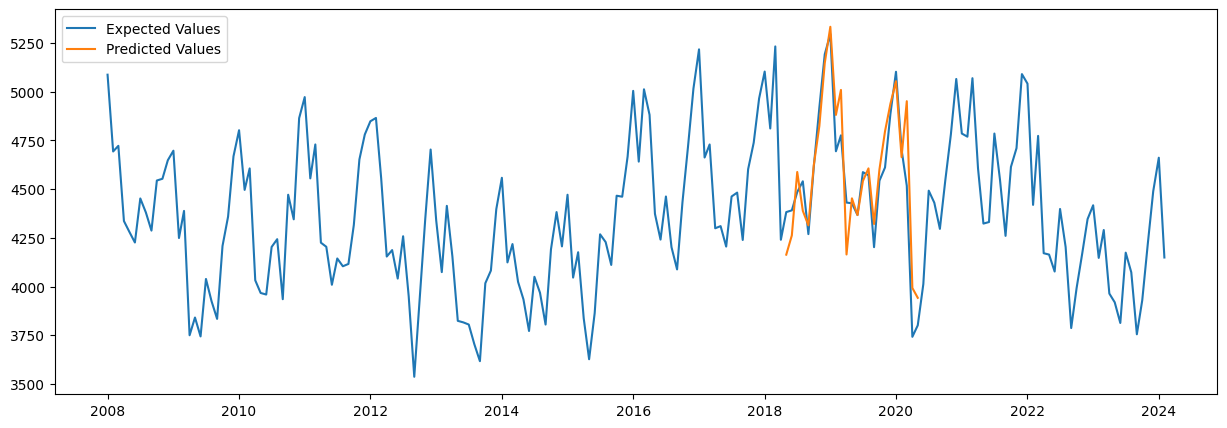

In [261]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['gWh_RO'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [262]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 155.6710


În medie, predicțiile modelului tău se abat cu 155 de unități de la valorile reale (155 GWh).În contextul dat, un RMSE de 155 este relativ mic.

In [263]:
mape = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.4f' % mape)

Test MAPE: 0.0266


Un MAPE de 0.02 înseamnă că eroarea medie între predicțiile modelului și valorile observate este de 2%, ceea ce este o valoare destul de mică.

În continuare, vom aplica modelul in-sample și vom alege o perioadă diferită de testare, respectiv ultimele 30 de luni disponibile.

In [37]:
size = int(len(df) - 30)
train, test = df['gWh_RO'][0:size], df['gWh_RO'][size:len(df)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (1,1,1),seasonal_order = (1,1,0,12))
    model_fit7 = model.fit()
    
    output = model_fit7.forecast()
    
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))
	 

	 SARIMA MODEL : In - Sample Forecasting 



C:\Users\tea20\AppData\Local\Temp\ipykernel_12824\2531130940.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted = 4327.175281, expected = 4260.000000
predicted = 4594.326208, expected = 4614.000000
predicted = 4771.595064, expected = 4710.000000
predicted = 5013.866123, expected = 5090.000000
predicted = 5062.100045, expected = 5041.000000
predicted = 4821.642834, expected = 4419.000000
predicted = 4546.367393, expected = 4773.000000
predicted = 4161.423442, expected = 4171.000000
predicted = 4061.281646, expected = 4164.000000
predicted = 4243.688274, expected = 4077.000000
predicted = 4582.009188, expected = 4398.000000
predicted = 4331.048298, expected = 4203.000000
predicted = 4070.716700, expected = 3787.000000
predicted = 4205.740095, expected = 3992.000000
predicted = 4291.816492, expected = 4168.000000
predicted = 4581.069344, expected = 4346.000000
predicted = 4276.359498, expected = 4417.000000
predicted = 4113.677628, expected = 4147.000000
predicted = 4467.175913, expected = 4290.000000
predicted = 3807.614206, expected = 3964.000000
predicted = 3788.077278, expected = 3919

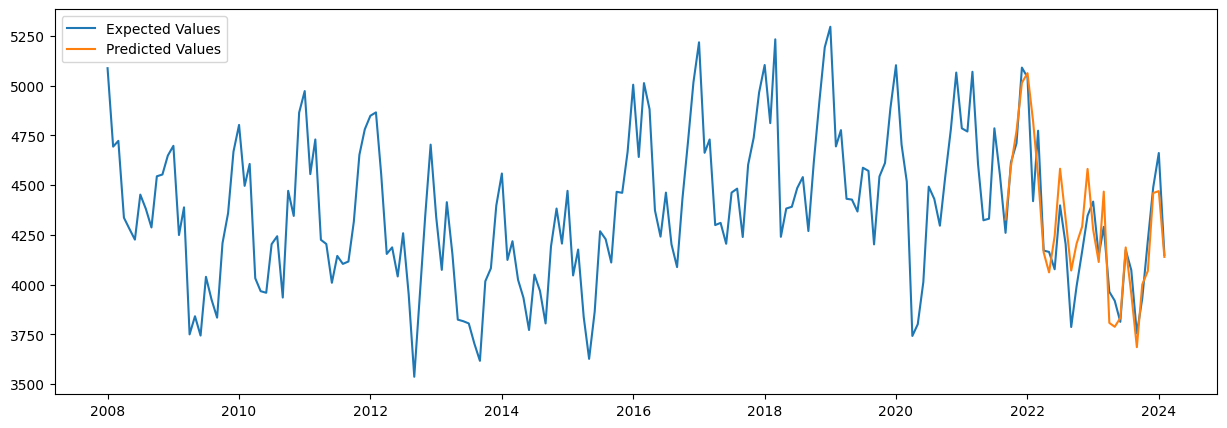

In [38]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['gWh_RO'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [266]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 151.9672


In [267]:
mape = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.4f' % mape)

Test MAPE: 0.0286


Valorile RMSE și MAPE sunt foarte apropiate de cele anterioare, cu o ușoară scădere a RMSE și o ușoară creștere a MAPE.

În continuare, vom testa out of sample, pentru următoarele 12 luni, cu ajutorul funcției forecast. Vom construi un nou dataframe cu datele previzionate.

In [48]:
future_dates = [df.index[-1] + DateOffset(months = x) for x in range(0,12)]
df1 = pd.DataFrame(index = future_dates[1:],columns = df.columns)

forecast = pd.concat([df,df1])
forecast['SARIMA_Forecast_Function'] = np.NaN
forecast=forecast.drop(['Month'], axis=1)
forecast=forecast.drop(['Year'], axis=1)
forecast=forecast.drop(['Date'], axis=1)

forecast.head()

,gWh_RO,SARIMA_Forecast_Function
2008-01-01,5087,NaN
2008-02-01,4693,NaN
2008-03-01,4722,NaN
2008-04-01,4336,NaN
2008-05-01,4281,NaN


In [50]:
SARIMA_history_f = [x for x in train]
f1 = []

for t in (range(len(df1))):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_f,order = (1,1,1),seasonal_order = (1,1,0,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    SARIMA_history_f.append(output)
    f1.append(output)
    
for i in range(len(f1)):
    forecast.iloc[194 + i,1] = f1[i]

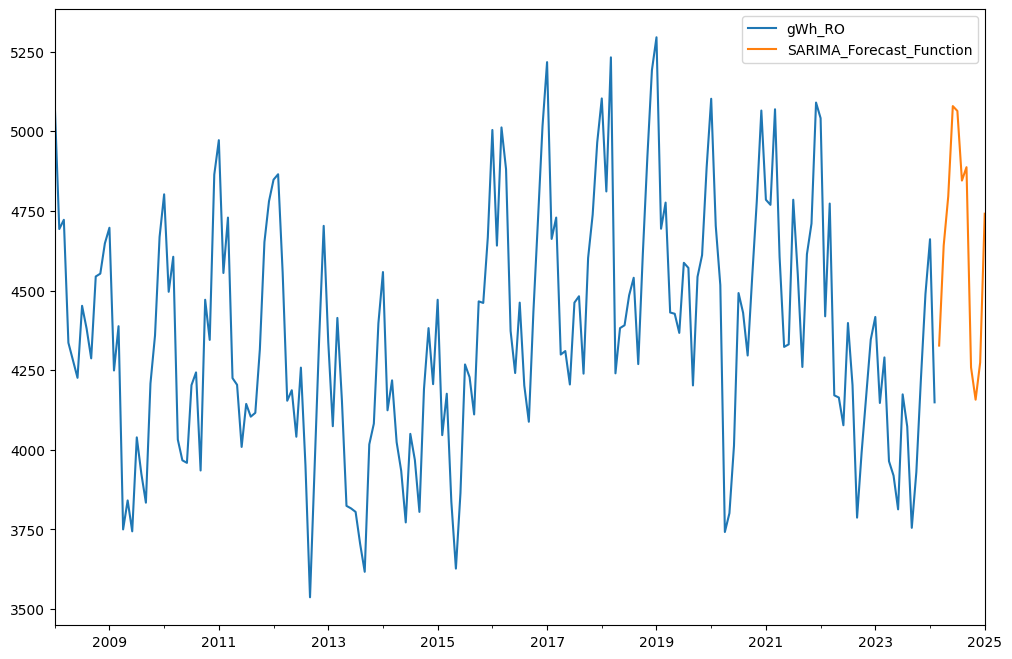

In [51]:
forecast[['gWh_RO','SARIMA_Forecast_Function']].plot(figsize = (12,8));

# Concluzii

* Cu ajutorul modelelor ARIMA și SARIMA, am încercat să realizăm o prognoză a unei serii temporale, respectiv consumul lunar de electricitate din România. Pentru ambele, am testat mai multe alternative și am ales modelul cel mai potrivit conform coeficienților semnificativi și criteriilor informaționale.

* Conform testelor de evaluare a performanței modelelor de predicție, modelul SARIMA este o alegere mai bună, având valorile RMSE și MAPE considerabil mai mici.

* După cum putem observa în prognozele out-of-sample, modelul SARIMA, care include termeni specifici pentru a modela sezonalitatea, a capturat mai eficient aceste fluctuații periodice decât modelul ARIMA, care nu include componentele sezoniere. Totuși, această prognoză poate fi îmbunătățită pe viitor.
